## 0. Load Data

In [3]:
from scipy.io import loadmat
data = loadmat('data/thyroid.mat')

In [4]:
gt = data['y']

In [5]:
import pandas as pd
df = pd.DataFrame(data['X'], columns=['Columns_%d'%i for i in range(data['X'].shape[1])])

In [6]:
from profiler.core import *

## 1. Instantiate Engine
* workers : number of processes
* tol     : tolerance for differences when creating training data (set to 0 if data is completely clean)
* eps     : error bound for inverse covariance estimation (since we use conservative calculation when determining minimum sample size, we recommend to set eps <= 0.01)
* embedtxt: if set to true, differentiate b/w textual data and categorical data, and use word embedding for the former

In [7]:
pf = Profiler(workers=2, tol=1e-6, eps=0.05, embedtxt=False)

## 2. Load Data
* name: any name you like
* src: \[FILE; DF; DB (not implemented)\]
* fpath: required if src == FILE
* df: required if src == DF
* check_param: print parameters used for data loading

In [8]:
pf.session.load_data(src=DF, df=df, check_param=True)

INFO:profiler.utility:[0.019629240036010742] Load Data start

INFO:profiler.dataset:parameters used for data loading:
 {'na_values': {'', 'NaN', 'nan', '?', 'none', 'unknown', 'None'}, 'sep': ',', 'header': 'infer', 'dropcol': None, 'dropna': False, 'encoding': 'utf-8', 'normalize': True, 'min_categories_for_embedding': 10}
INFO:profiler.dataset:inferred types of attributes: {
    "Columns_0": "numeric",
    "Columns_1": "numeric",
    "Columns_2": "numeric",
    "Columns_3": "numeric",
    "Columns_4": "numeric",
    "Columns_5": "numeric"
}
INFO:profiler.dataset:(possible types: numeric, categorical, text, date)
INFO:profiler.dataset:inferred operators of attributes: {'Columns_0': ['equal'], 'Columns_1': ['equal'], 'Columns_2': ['equal'], 'Columns_3': ['equal'], 'Columns_4': ['equal'], 'Columns_5': ['equal']}
INFO:profiler.dataset:(possible operators: equal, notequal, greater_than, less_than)
INFO:profiler.utility:[0.03742718696594238] Load Data execution time: 0.01779794692993164



In [9]:
pf.session.ds.df.head()

,Columns_0,Columns_1,Columns_2,Columns_3,Columns_4,Columns_5
0,0.774194,0.001132,0.137571,0.275701,0.295775,0.236066
1,0.247312,0.000472,0.279886,0.329439,0.535211,0.173770
2,0.494624,0.003585,0.222960,0.233645,0.525822,0.124590
3,0.677419,0.001698,0.156546,0.175234,0.333333,0.136066
4,0.236559,0.000472,0.241935,0.320093,0.333333,0.247541


### 2.1 Change Data Types of Attributes
* required input:
    * a list of attributes
    * a list of data types (must match the order of the attributes; can be CATEGORICAL, NUMERIC, TEXT, DATE)
* optional input:
    * a list of regular expression extractor

In [10]:
# pf.session.change_dtypes(['ProviderNumber', 'ZipCode', 'PhoneNumber', 'State', 'EmergencyService','Score', 'Sample'], 
#                             [CATEGORICAL, NUMERIC, CATEGORICAL, TEXT, TEXT, NUMERIC, NUMERIC],
#                             [None, None, None, None, None, r'(\d+)%', r'(\d+)\spatients'])

### 2.2. Load/Train Embeddings for TEXT
* path: path to saved/to-save embedding folder
* load: set to true -- load saved vec from 'path'; set to false -- train locally
* save: (only for load = False) save trained vectors to 'path'

In [11]:
#pf.session.load_embedding(save=True, path='data/hospital/', load=True)

## 3. Load Training Data
* multiplier: if set to None, will infer the minimal sample size; otherwise, it will create (# samples) * (# attributes) * (multiplier) training samples

In [12]:
pf.session.load_training_data(multiplier = None)

INFO:profiler.utility:[1.2894492149353027] Create Training Data start

INFO:profiler.transformer:needs multiplier = 4 to bound the error in inv cov estimation <= 0.05000000
INFO:profiler.transformer:use multiplier = 4, and the bound is 0.00028507
INFO:profiler.transformer:Draw Pairs
100%|██████████| 6/6 [00:00<00:00, 182.43it/s]
INFO:profiler.transformer:Number of training samples: 22632
INFO:profiler.transformer:Computing Differences
INFO:profiler.transformer:estimated missing data probability in training data is 0.0000
INFO:profiler.utility:[1.4193532466888428] Create Training Data execution time: 0.12990403175354004



## 4. Learn Structure
* sparsity: intensity of L1-regularizer in inverse covariance estimation (glasso)
* take_neg: if set to true, consider equal -> equal only

In [15]:
autoregress_matrix = pf.session.learn_structure(sparsity=0,
                                                infer_order=True)

INFO:profiler.utility:[8.270657062530518] Learn Structure start

INFO:profiler.learner:use threshold 0.0511
INFO:profiler.utility:[8.381498098373413] Learn Structure execution time: 0.11084103584289551



* score: 
    * "fit_error": mse for fitting y = B'X + c for each atttribute y 
    * "training_data_fd_vio_ratio": the higher the score, the more violations of FDs in the training data. (bounded: \[0,1\])

In [16]:
parent_sets = pf.session.get_dependencies(score="fit_error")


INFO:profiler.utility:[9.218231201171875] Get Dependencies start

INFO:profiler.utility:[9.227264165878296] Get Dependencies execution time: 0.009032964706420898



## 5. Visualization

In [17]:
pf.session.visualize_covariance()

<Figure size 1000x800 with 2 Axes>

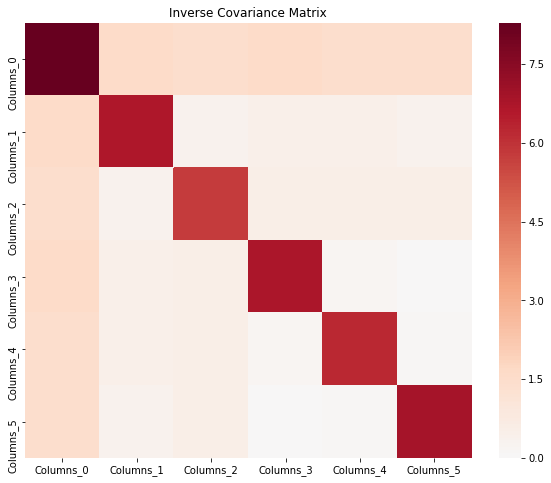

In [18]:
pf.session.visualize_inverse_covariance()

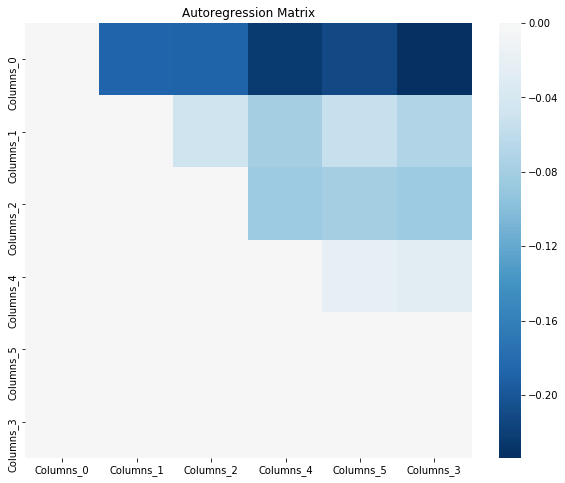

In [19]:
pf.session.visualize_autoregression()

In [20]:
pf.session.timer.get_stat()


,time_point,msg,execution_time
0,0.019629,start: Load Data,0.000000
1,0.037427,end: Load Data,0.017798
2,1.289449,start: Create Training Data,0.000000
3,1.419353,end: Create Training Data,0.129904
4,2.475180,start: Learn Structure,0.000000
5,2.574278,end: Learn Structure,0.099098
6,3.378386,start: Get Dependencies,0.000000
7,3.387433,end: Get Dependencies,0.009047
8,8.270657,start: Learn Structure,0.000000
9,8.381498,end: Learn Structure,0.110841


In [21]:
gt = gt.reshape(-1,)
gt_idx = np.array(range(gt.shape[0]))[gt == 1]

In [22]:
def outlier(data, m=4):
    return abs(data - np.mean(data)) > m * np.std(data)

def prec_recall(outliers, gt_idx):
    outliers = set(outliers)
    tp = 0.0
    # precision
    if len(outliers) == 0:
        print("no outlier is found")
        recall(tp, outliers, gt_idx)
        print("f1: 0")
        return 0
    for i in outliers:
        if i in gt_idx:
            tp += 1
    prec = tp / len(outliers)
    print("with %d detected outliers, precision is: %.4f"%(len(outliers), prec))
    rec = recall(tp, outliers, gt_idx)
    print("f1: %.4f"%(2 * (prec * rec) / (prec + rec)))
    
def recall(tp, outliers, gt_idx):
    if tp == 0:
        print("with %d outliers in gt, recall is: 0"%(len(gt_idx)))
        return 0 
    print("with %d detected outliers, recall is: %.4f"%(len(outliers), tp / len(gt_idx)))
    return tp / len(gt_idx)




In [23]:
import sklearn
def cmpr_detection(df, left, right, m1=3, m2=3):
    overall=df.index.values[outlier(df[right],m=m1)]
    outliers = []
    if len(left) == 0:
        return overall, outliers
    i = 0
    X = df[left].values.reshape(-1,len(left))
    # distances = sklearn.metrics.pairwise_distances(X)
    # calculate pairwise distance for each attribute
    distances = np.zeros((X.shape[0],X.shape[0]))
    for j in range(X.shape[1]):
        dis = sklearn.metrics.pairwise_distances(X[:,j].reshape(-1,1), metric='cityblock')
        # normalize distance
        dis = dis / np.nanmax(dis)
        distances = (dis <= 1e-6)*1 + distances
    indices = np.array(range(distances.shape[0]))
    for row in distances:
        nbr = indices[row == X.shape[1]]
        outliers.extend(nbr[outlier(df[right].values[nbr], m=m2)])
        i += 1
    return overall, outliers

In [24]:
from tqdm import tqdm
base = []
improv = []
for child in tqdm(parent_sets):
    overall, structured = cmpr_detection(df, parent_sets[child], child, m1=3, m2=5)
    base.extend(list(overall))
    improv.extend(structured)
unique, count = np.unique(improv, return_counts=True)
improv = list(unique[count > 100])
improv.extend(list(base))
print("naive approach: ")
prec_recall(base, gt_idx)
print("with structural constraints: ")
prec_recall(improv, gt_idx)

100%|██████████| 6/6 [00:00<00:00, 409.78it/s]

naive approach: 
with 197 detected outliers, precision is: 0.2081
with 197 detected outliers, recall is: 0.4409
f1: 0.2828
with structural constraints: 
with 197 detected outliers, precision is: 0.2081
with 197 detected outliers, recall is: 0.4409
f1: 0.2828
